<h1><center>Caso práctico final módulo Aprendizaje automático</center></h1>
<h3><center>Empresa retail: clasificar a los clientes en función de la probabilidad de generar ingresos al comprar en la web </center></h3>
<h3>Descripción de los datos:</h3>

* El conjunto de datos consta de diez atributos numéricos y ocho categóricos.
* El atributo **revenue** puede ser usado como la etiqueta de la clase.
* **Administrative, administrative duration, informational, informational duration, product related y product related duration** representan el número de diferentes tipos de páginas visitadas por el visitante en esa sesión y el tiempo total dedicado a cada una de estas categorías de páginas. Los valores de estas características se derivan de la información del URL de las páginas visitadas por el usuario y se actualizan en tiempo real cuando el usuario realiza una acción, por ejemplo, pasar de una página a otra.
* Las características **bounce rate, exit rate y page value** representan las métricas medidas por Google Analytics para cada página del sitio de comercio electrónico. 
* El valor de la característica **bounce rate** de una página web se refiere al porcentaje de visitantes que entran en el sitio desde esa página y luego salen (rebote) sin activar ninguna otra solicitud al servidor de análisis durante esa sesión.
* El valor de la característica **exit rate** para una página web específica se calcula como para todas las visitas a la página, el porcentaje que fueron las últimas en la sesión.
* La **función Page Value** representa el valor medio de una página web que un usuario ha visitado antes de completar una transacción de comercio electrónico.
* La característica de **special day** indica la cercanía de la hora de visita del sitio a un día especial específico (por ejemplo, el Día de la Madre, San Valentín) en el que es más probable que las sesiones finalicen con una transacción.El valor de este atributo se determina teniendo en cuenta la dinámica del comercio electrónico, como la duración entre la fecha del pedido y la fecha de entrega. Por ejemplo, para San Valentín, este valor toma un valor distinto de 0 entre el 2 y el 12 de febrero, 0 antes y después de esta fecha a menos que esté cerca de otro día especial, y su valor máximo de 1 el 8 de febrero.
* El conjunto de datos también incluye **el sistema operativo, el navegador, la región, el tipo de tráfico, el tipo de visitante como visitante que regresa o como nuevo visitante, un valor booleano que indica si la fecha de la visita es de fin de semana, y el mes del año.**


<h3>Analisis del dataset de Google Analytics</h3>
 

<h4>Carga de librerías</h4>

In [509]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

from IPython.core.display import display, HTML
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import warnings
warnings.filterwarnings('ignore')

**Definición de Funciones**

In [510]:
def relaciones_vs_target(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', density=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4.; fig_tamanio = 4.
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   density = density, title=('%s' % feat))

<h4>Carga de datos</h4>

In [298]:
XY = pd.read_csv('./online_shoppers_intention.csv', sep=',', index_col=False)

In [299]:
XY[:5]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


<h4>Exploración de datos; procesamiento y visualización</h4>

 Contabilizamos Nº de features, si tienen nan y el tipo que es cada una. El conjunto tiene 17 variables dependientes y la variable **Revenue** (target), con un total de 12330 filas.

In [300]:
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables son: {}'.format(list(XY.columns)))
XY[:2]

- El número de filas en el dataset es: 12330
- El número de columnas en el dataset es: 18
- Los nombres de las variables son: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False


In [301]:
XY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

* Hay 4 feautres de tipo entero, 2 feaures de tipo objetos, 10 features de tipo decimal, 1 feature de tipo booleano y la target booleana también. 
* Hay 14 missing values en las 7 priemeras features. 

In [302]:
#Descripción cuantitativa de estadisticos básicos
XY.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [303]:
# División de los datos en features y target 
X = XY.drop('Revenue', axis=1)
Y = XY['Revenue']

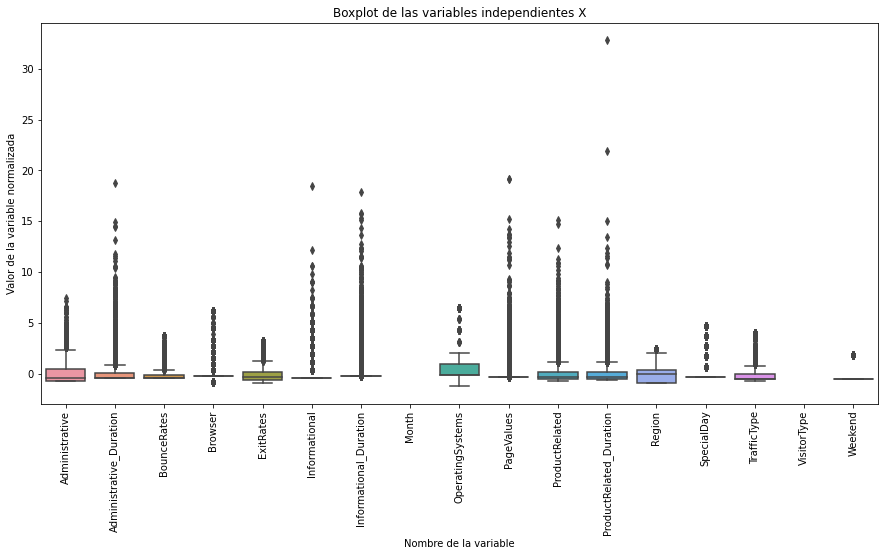

In [304]:
# Representa los boxplot
# Normaliza para tener rangos comparables en las features. No se normaliza la target
X_normalizado = (X-X.mean())/X.std()

plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Boxplot de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

Se puede ver que algunas de las features contienen valores anómalos como por ejemplo (adminsitrative_duration o Informatinal)

array([[<AxesSubplot:title={'center':'Administrative'}>,
        <AxesSubplot:title={'center':'Administrative_Duration'}>,
        <AxesSubplot:title={'center':'Informational'}>,
        <AxesSubplot:title={'center':'Informational_Duration'}>],
       [<AxesSubplot:title={'center':'ProductRelated'}>,
        <AxesSubplot:title={'center':'ProductRelated_Duration'}>,
        <AxesSubplot:title={'center':'BounceRates'}>,
        <AxesSubplot:title={'center':'ExitRates'}>],
       [<AxesSubplot:title={'center':'PageValues'}>,
        <AxesSubplot:title={'center':'SpecialDay'}>,
        <AxesSubplot:title={'center':'OperatingSystems'}>,
        <AxesSubplot:title={'center':'Browser'}>],
       [<AxesSubplot:title={'center':'Region'}>,
        <AxesSubplot:title={'center':'TrafficType'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

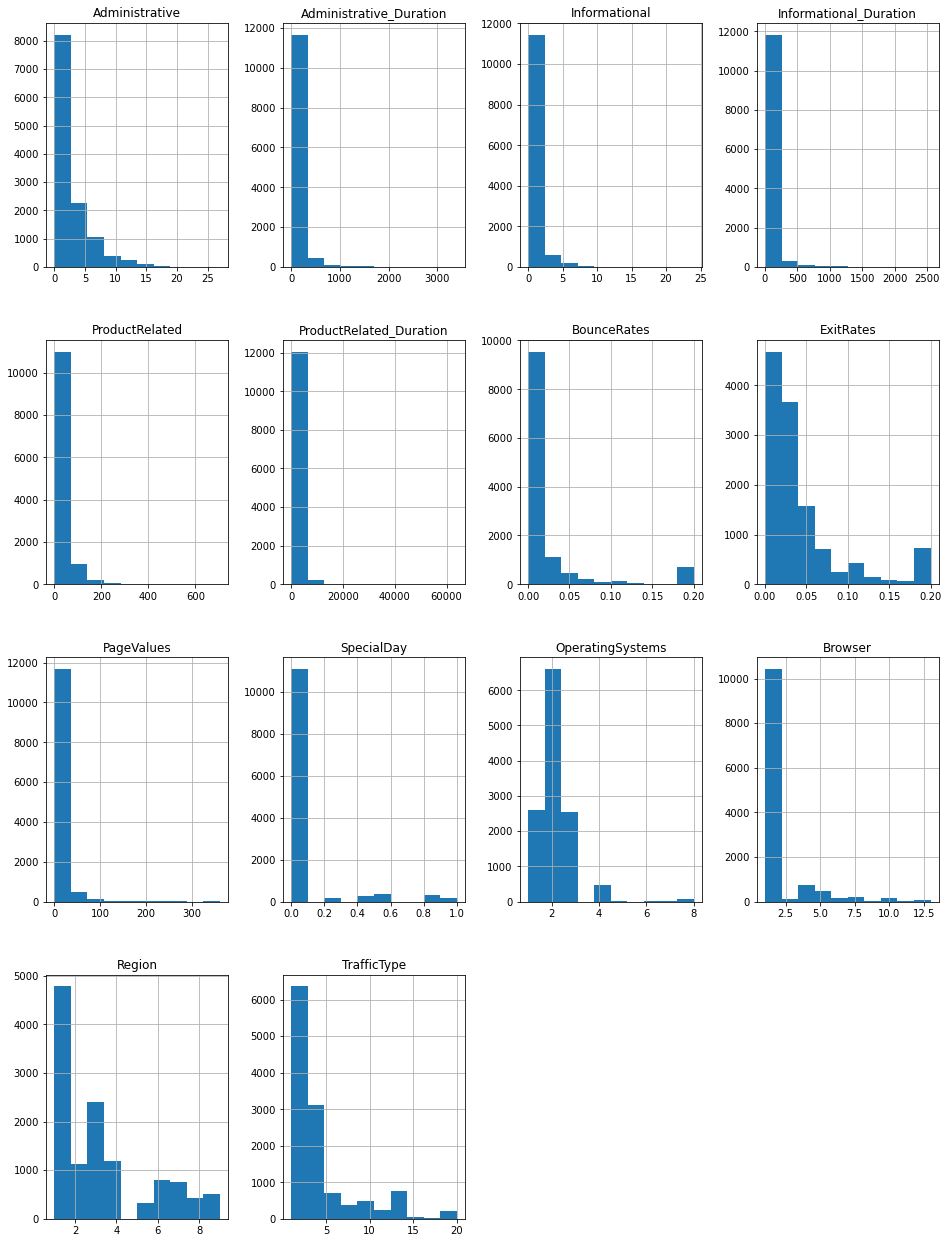

In [305]:
XY.select_dtypes(include=['int64', 'float64']).hist(figsize=(16,22)) #Histogramas de variables numericas

Pintamos la variable target para ver comportamiento

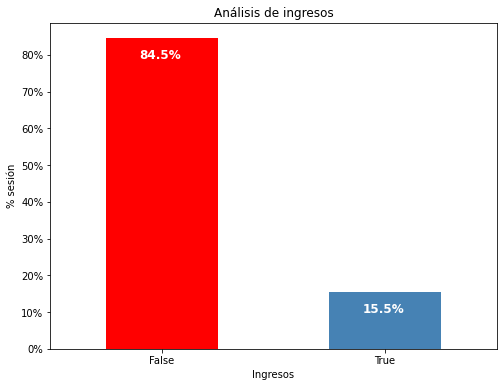

In [306]:
plt.figure(figsize = (8,6))
colors = ['red','steelblue']

ax1 = (XY['Revenue'].value_counts()*100.0 /len(XY)).plot(kind='bar', stacked = True,
                    rot = 0,color=colors)

ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_ylabel('% sesión')
ax1.set_xlabel('Ingresos')
ax1.set_title('Análisis de ingresos')
totals = []

for i in ax1.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax1.patches:
    ax1.text(i.get_x()+.15, i.get_height()-5.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
            weight = 'bold')

Se ve que el 84.5% de las sesiones no generan ingresos, sólo el 15.5% sí.

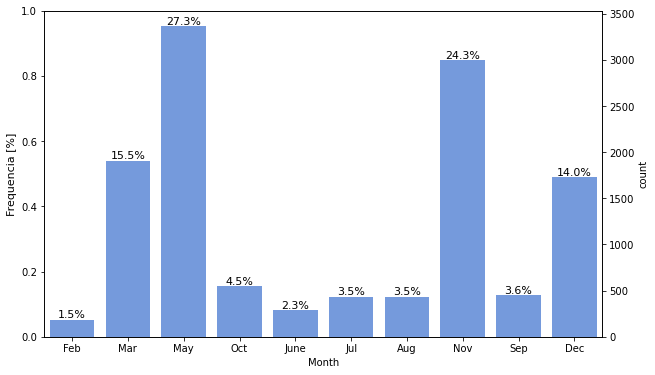

In [307]:
colors = ['cornflowerblue']
ncount = len(XY)
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.countplot(x=XY['Month'], data=XY, palette=colors)

ax2=ax.twinx()

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequencia [%]',fontsize=11)

for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom', fontsize=11) 
        
plt.show()

Los meses que presentan mayores fecuencia de sesiones son Mayo y Noviembre. Los meses en los que menos conexiones a la web hubo fueron febrero y junio.

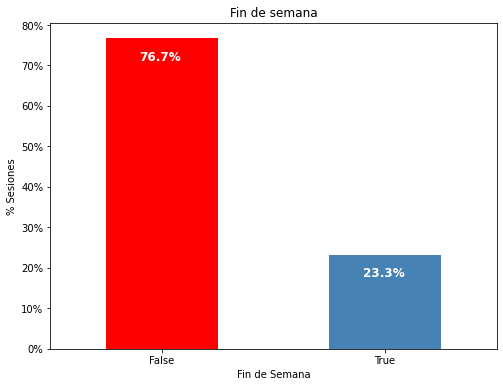

In [308]:
plt.figure(figsize = (8,6))
colors = ['red','steelblue']

ax1 = (XY['Weekend'].value_counts()*100.0 /len(XY)).plot(kind='bar', stacked = True,
                    rot = 0,color=colors)

ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_ylabel('% Sesiones')
ax1.set_xlabel('Fin de Semana')
ax1.set_title('Fin de semana')
totals = []

for i in ax1.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax1.patches:
    ax1.text(i.get_x()+.15, i.get_height()-5.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
            weight = 'bold')


La mayoría de las sesiones se hicieron entre semana, menos del 25% fueron realizadas durante el fin de semana.

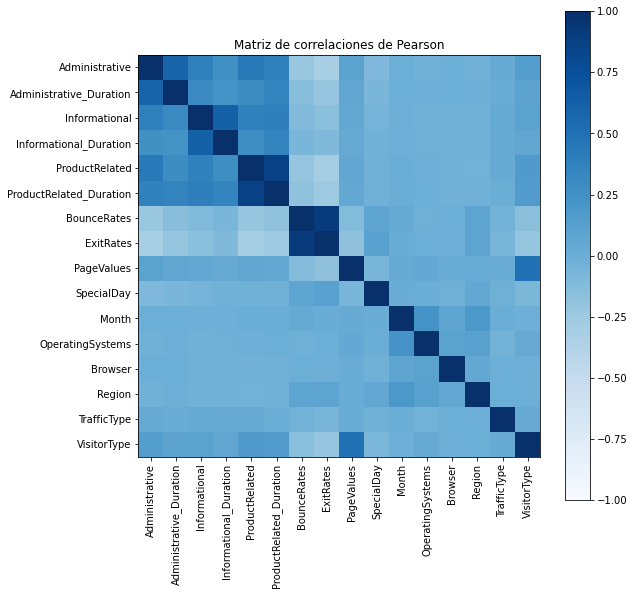

In [309]:
# Representa la matriz de correlaciones
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

In [310]:
# Obtén las variables más y menos correlacionadas con la target
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
PageValues,0.492569
ExitRates,-0.206886
ProductRelated,0.158280
ProductRelated_Duration,0.152130
BounceRates,-0.150621
Administrative,0.138631
Informational,0.095085
Administrative_Duration,0.093395
SpecialDay,-0.082305
Informational_Duration,0.070250


Si se analiza el resultado de la matriz de correlación, se obtiene que hay correlaciones( tanto positivas como negativas) muy bajas (-0,01 a -0,19 0 0.01 a 0.19) con target. Sin embargo, encontramos una correlacion positiva media con PageValues.

<h4>Procesamiento de los datos<h4>

In [311]:
#Eliminaremos datos faltantes. Usaremos el método dropna().
XY.isnull().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [312]:
XY.dropna(inplace=True)#eliminamos NaNs
XY.isnull().sum() #chequamos que se hayan eliminado

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [313]:
# Lista de variables categóricas
XY.select_dtypes(exclude=['number']).columns

Index(['Month', 'VisitorType', 'Weekend', 'Revenue'], dtype='object')

In [314]:
le = LabelEncoder() #usaremos label encoder para codificar las variables categoricas a numericas.

In [315]:
XY.Month= le.fit_transform(XY.Month)
XY.VisitorType= le.fit_transform(XY.VisitorType)
XY.Weekend= le.fit_transform(XY.Weekend)
XY.Revenue= le.fit_transform(XY.Revenue)
#Hemos modificado para cada una de las variables catogricas de nuestro DataFrame los valores a numéricos siendo para Month valores de 0 a 11, los de Revenue de 0 a 1 y así para cada variable en función de sus n valores posibles. 

In [316]:
XY[:6] #chequeamos que se hayan modificado las columnas en el DataFrame. Se decide sobreescribirlas en vez de generar columnas nuevas porque será más eficiente para el resto del estudio.

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.0,0.0,2,1,1,1,1,2,0,0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.0,0.0,2,2,2,1,2,2,0,0
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.0,0.0,2,4,1,9,3,2,0,0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.0,0.0,2,3,2,2,4,2,0,0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.0,0.0,2,3,3,1,4,2,1,0
5,0.0,0.0,0.0,0.0,19.0,154.216667,0.015789,0.024561,0.0,0.0,2,2,2,1,3,2,0,0


Este Dataset contiene como se ha podido observar anteriormente. Todas las variables proporcionan información útil para el objetivo propuesto, pero se decide eliminar **OperatingSystems**, **Browser** and **TrafficType** ya que no creemos relevante en este caso que el tipo de sistema operativo o el buscador que se use o el tipo de trafico influyan en la generación de ingresos o no. 



In [317]:
XY.drop(['OperatingSystems','Browser','TrafficType'],axis=1)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Region,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,2,1,2,0,0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.000000,0.0,2,1,2,0,0
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.000000,0.0,2,9,2,0,0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.000000,0.0,2,2,2,0,0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.000000,0.0,2,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3.0,145.0,0.0,0.0,53.0,1783.791667,0.007143,0.029031,12.241717,0.0,1,1,2,1,0
12326,0.0,0.0,0.0,0.0,5.0,465.750000,0.000000,0.021333,0.000000,0.0,7,1,2,1,0
12327,0.0,0.0,0.0,0.0,6.0,184.250000,0.083333,0.086667,0.000000,0.0,7,1,2,1,0
12328,4.0,75.0,0.0,0.0,15.0,346.000000,0.000000,0.021053,0.000000,0.0,7,3,2,0,0


Ploteamos los datos para ver comportamiento una vez limpiado el dataset

In [318]:
# División de los datos en features y target tratados
X = XY.drop('Revenue', axis=1)
Y = XY['Revenue']

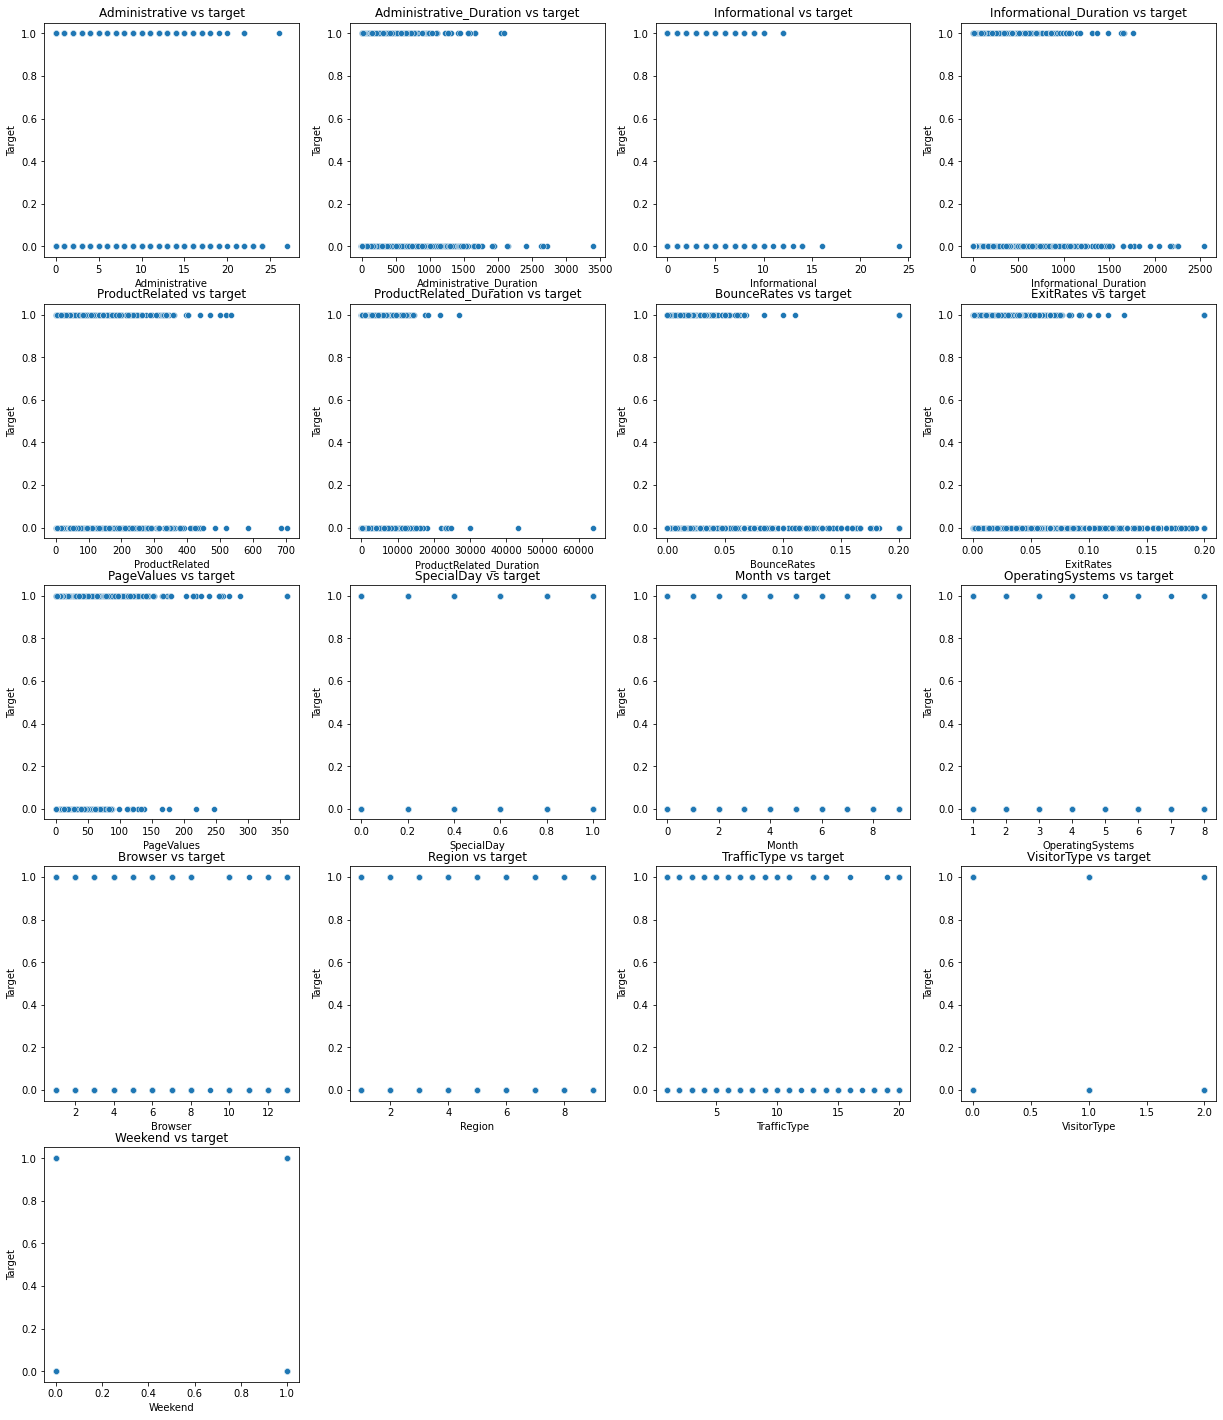

In [319]:
relaciones_vs_target(X, Y) #Pintamos las relaciones de las variables ya procesadas con la variable objetivo para ver su comportamiento

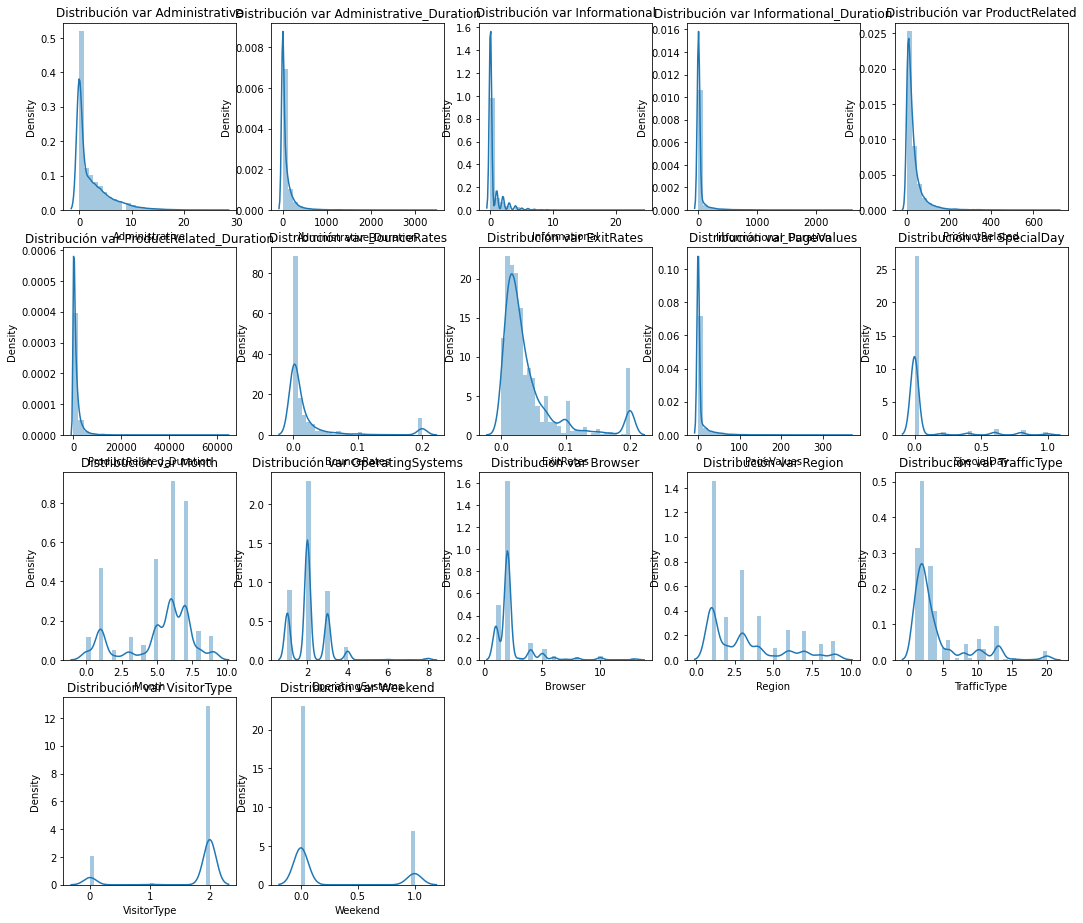

In [320]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X.columns):
    n+=1
    plt.subplot(5, 5, n)
    sns.distplot(X[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

<h4>Estandarizamos<h4>

In [321]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

In [322]:
# Dividimos los datos en train y test, con un 20 % de tamaño de test
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

<h4> Regresión Logística <h4>

In [448]:
# Ajustamos el modelo de regresión lógistica a los datos de entrenamiento y prededimos test
modelo = LogisticRegression()
modelo.fit(X_train, Y_train)

LogisticRegression()

In [449]:
# Predecir las probabilidades- en Test y calcular la métrica ROC AUC
y_test_pred_prob = modelo.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

0.884591281486916

In [437]:
#Optimización de los parámetros
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09], 
              "class_weight":['balanced', None]}
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [438]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'C': 0.09, 'class_weight': 'balanced'} 
ROC AUC: 0.89


In [439]:
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

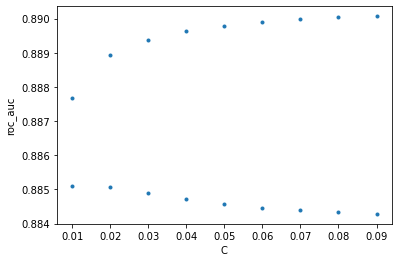

In [440]:
#representamos métrica en relación al parámetro C
plt.xlabel('C')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_C'], df_search['mean_test_score'], '.')

In [467]:
#vemos si la optimización ha mejorado el modelo
y_test_pred_prob = modelo_gs.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

0.8932234348251407

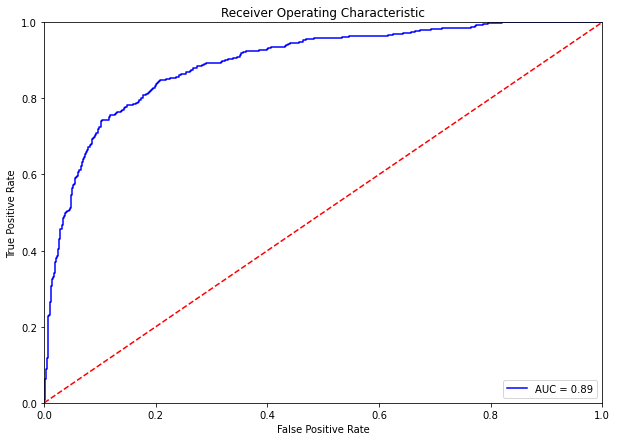

In [468]:
# Representa la curva ROC de las predicciones en Test
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h4> Modelo Redes Neuronales <h4>

In [484]:
modelo = MLPClassifier()
parametros = {'solver': ['lbfgs'], 
              'max_iter': [100,200,300,500], # Iteraciones máximas en cada red
              'alpha': 10.0 ** -np.arange(1, 3), # Parámetro de regularización L2 para evitar sobreajuste
              'hidden_layer_sizes':np.arange(30, 35), # Número de neuronas en cada capa
              'random_state':[0]}

In [485]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros, cv = 3, 
                         scoring='roc_auc', n_jobs=-1, verbose=10)
modelo_gs.fit(X_train, Y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'alpha': array([0.1 , 0.01]),
                         'hidden_layer_sizes': array([30, 31, 32, 33, 34]),
                         'max_iter': [100, 200, 300, 500], 'random_state': [0],
                         'solver': ['lbfgs']},
             scoring='roc_auc', verbose=10)

In [486]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'alpha': 0.1, 'hidden_layer_sizes': 30, 'max_iter': 100, 'random_state': 0, 'solver': 'lbfgs'} 
ROC AUC: 0.89


In [487]:
mejor_modelo = MLPClassifier(**modelo_gs.best_params_, verbose=10)

In [488]:
mejor_modelo.fit(X_train, Y_train)

MLPClassifier(alpha=0.1, hidden_layer_sizes=30, max_iter=100, random_state=0,
              solver='lbfgs', verbose=10)

In [489]:
y_test_pred_prob = mejor_modelo.predict_proba(X_test) 
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

In [490]:
#vemos si la optimización ha mejorado el modelo
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

0.8929852449661694

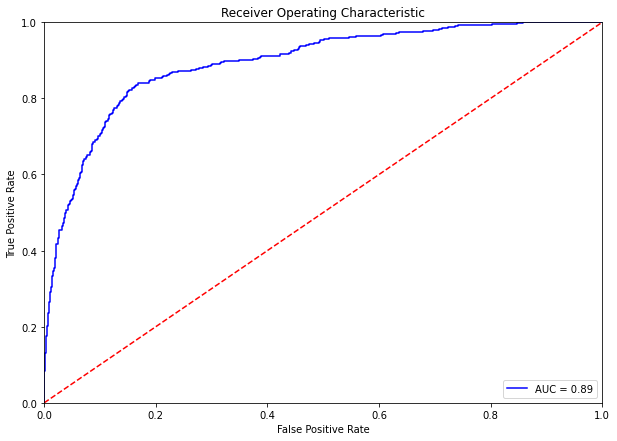

In [491]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h4> Módelo de Clasificación KNN <h4>

In [492]:
from sklearn.model_selection import train_test_split 
import scikitplot as skplt
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import GridSearchCV

In [493]:
modelo_knn = KNeighborsClassifier()
k_range = list(range(1, 15))
param_grid = dict(n_neighbors=k_range)

In [494]:
modelo_gs = GridSearchCV(modelo_knn, param_grid,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14]},
             scoring='roc_auc')

In [495]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'n_neighbors': 14} 
ROC AUC: 0.83


In [496]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
knn = KNeighborsClassifier(n_neighbors = 14)
knn.fit(X_train,Y_train)


KNeighborsClassifier(n_neighbors=14)

In [497]:
y_scores = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

In [498]:
#vemos el valor exacto de auc
metrics.roc_auc_score(Y_test, y_scores[:,1])

0.828800083557512

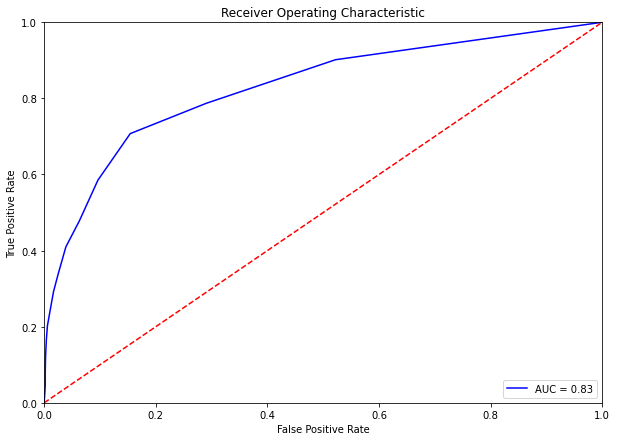

In [499]:
#pintamos curva ROC
plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h4> Mejor modelo: Regresión Logística

Si se analiza el valor de AUC de cada modelo, y el comportamiento de la curva ROC, se puede decir que el modelo KNN es el que peor se ajusta, entre el modelo de redes neuronales y el de regresión logistica no hay apenas diferencias. Sin embargo, ya que su valor es relativamente mayor y el comportamiento en su gráfica mejor ( más proximo a 1, observese la pequeña discrepancia entre la curva ROC del modelo de regresión logística y el modelo de redes neuronales). Seguramente si aumentasemos el número de neuronas en cada capa, el modelo de redes neuronales presentaría un AUC ligeramente superior al de regresión logística. 

Nos quedamos con las probabilidades obtenidas con el modelo de regresión logística y Umbralizar las probabilidades utilizando el umbral que maximice el área bajo la curva ROC. Para que sea más fácil su interpretación y conclusión del ejercicio se decide volver a calcular el modelo a continuación (computacionalmente esto no es eficiente, ya que está el modelo calculado lineas arriba, sólo lo hacemos para que el ejercico sea más fácil de ver).

In [500]:
# Ajustamos el modelo de regresión lógistica a los datos de entrenamiento y prededimos test
modelo = LogisticRegression()
modelo.fit(X_train, Y_train)
# Predecir las probabilidades- en Test y calcular la métrica ROC AUC
y_test_pred_prob = modelo.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

0.884591281486916

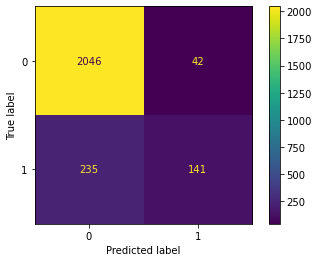

In [501]:
plot_confusion_matrix(modelo,X_test,Y_test) 

In [502]:
#Optimización de los parámetros
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09], 
              "class_weight":['balanced', None]}
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [503]:
y_test_pred_prob = modelo_gs.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]


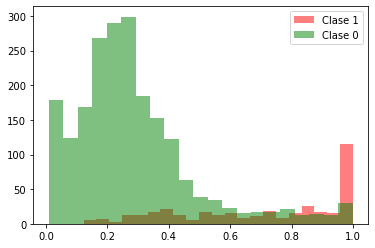

In [504]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

In [505]:
sensitividades = {}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    sensitividades[umbral] = metrics.recall_score(Y_test, y_umbralizadas)
sensitividades

{0.1: 1.0,
 0.2: 0.9680851063829787,
 0.3: 0.9069148936170213,
 0.5: 0.7393617021276596,
 0.6: 0.648936170212766,
 0.8: 0.4920212765957447}

In [506]:
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8,0.9]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(Y_test, y_umbralizadas)
precisiones

{0.1: 0.17319207738369416,
 0.2: 0.2143698468786808,
 0.3: 0.32139491046182844,
 0.5: 0.563894523326572,
 0.6: 0.6146095717884131,
 0.8: 0.7115384615384616,
 0.9: 0.7653631284916201}

In [507]:
umbral = 0.7
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [508]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))  

Matriz de confusión
 [[1973  115]
 [ 159  217]]

Accuracy	0.89
Sensitividad	0.58
Precisión	0.65


Tras observar los valores de los diferentes umbrales, se decide utilizar 0.7, ya que a la vista de los resultados parece ser el que mejores resultados presenta.